<a href="https://colab.research.google.com/github/mrinalikadasari18-code/Customer-Segmentation-and-Recommendation-System/blob/main/Customer_Segmentation_and_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#Step 1.1 Importing Necessary Libraries
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [21]:
#Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [22]:
#configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [24]:
#Step 1.2 Loding the Dataset

df = pd.read_csv('data.csv', encoding="ISO-8859-1")

In [26]:
#Step 2.1 Dataset Overview

df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.0,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6.0,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6.0,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6.0,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32.0,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363732 entries, 0 to 363731
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    363732 non-null  object 
 1   StockCode    363732 non-null  object 
 2   Description  362477 non-null  object 
 3   Quantity     363731 non-null  float64
 4   InvoiceDate  363731 non-null  object 
 5   UnitPrice    363731 non-null  float64
 6   CustomerID   267010 non-null  float64
 7   Country      363731 non-null  object 
dtypes: float64(3), object(5)
memory usage: 22.2+ MB


In [30]:
#Step 2.2 Summary Statistics

#Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,363731.0,9.808144,183.102093,-74215.00,1.00,3.0,10.00,74215.0
UnitPrice,363731.0,4.814054,107.994176,-11062.06,1.25,2.1,4.13,38970.0
CustomerID,267010.0,15276.450620,1718.494451,12346.00,13871.00,15150.0,16791.00,18287.0


In [32]:
#Summary sattistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,363732,18473,558475,705
StockCode,363732,3881,85123A,1788
Description,362477,3935,WHITE HANGING HEART T-LIGHT HOLDER,1834
InvoiceDate,363731,16690,6/29/2011 15:58,705
Country,363731,37,United Kingdom,331840


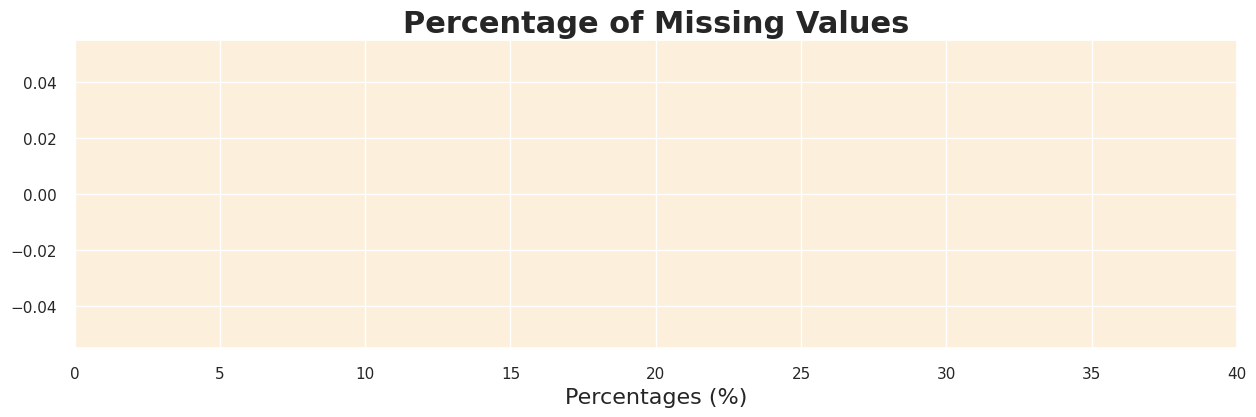

In [52]:
#Step 3.1 Handling Missing Values
#Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage  = (missing_data[missing_data > 0] /df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

#Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

#Annotate the values and indexes
for i,(value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

#Set x-axis limit
ax.set_xlim([0,40])

#Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [48]:
#Extracting rows with missing values in 'CustomerID' or 'Description' columns
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [53]:
#Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID', 'Description'])

In [55]:
#verify the removal of missing values
df.isnull().sum().sum()

np.int64(0)

In [56]:
#Step 3.2 Handing Duplicates
#Find duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

#Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

#Displaying the first 10 records
duplicate_rows_sorted.head(10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [58]:
#Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

#Removing duplicate rpws
df.drop_duplicates(inplace=True)

The dataset contains 0 duplicate rows that need to be removed.


In [60]:
#Getting the number of rows in the dataframe
df.shape[0]

264230

In [61]:
#Step 3.3 Treating Cancelled Transactions
#Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

#Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] =='Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,6213.000000,6213.000000
mean,-24.669242,21.539590
std,951.615750,525.086912
min,-74215.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


In [62]:
#Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

#Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transcations in the dataset is: {cancelled_percentage:.2f}%")


The percentage of cancelled transcations in the dataset is: 2.35%


In [63]:
#Step 3.4 Correcting StockCode Anomalies
#Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

#Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")


The number of unique stock codes in the dataset is: 3516


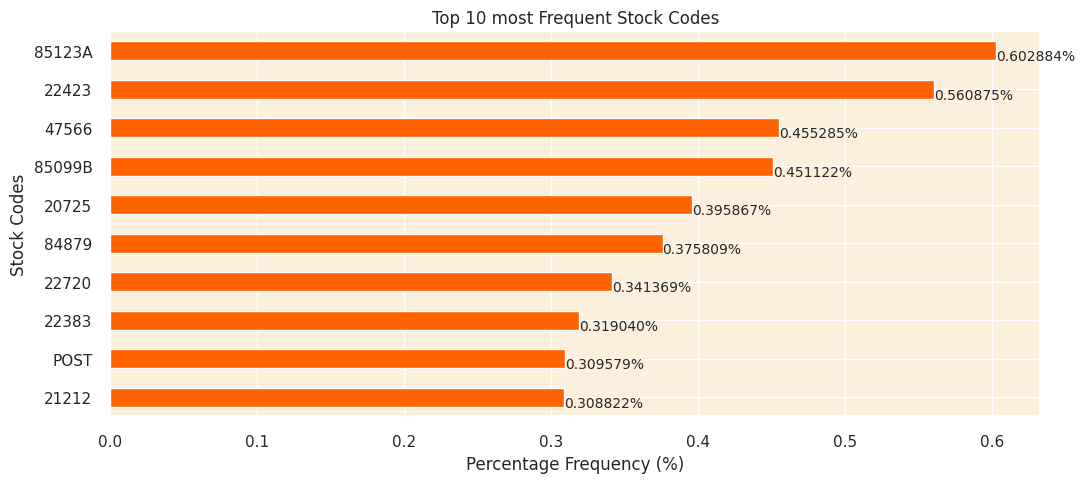

In [68]:
#finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

#Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

#Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
  plt.text(value, index+0.25, f'{value:2f}%', fontsize=10)

plt.title('Top 10 most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [69]:
#Finding the number of numeric characters in each unique stock code
unique_stock_codes_= df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

#printing the value counts for unique stock codes
print("Values counts of numeric characters in unique stock codes:")
print(numeric_char_counts_in_unique_codes)

Values counts of numeric characters in unique stock codes:
4    1
Name: count, dtype: int64


In [75]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes_ if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
  print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [77]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.50%


In [79]:
#Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [80]:
# Getting the number of rows in the dataframe
df.shape[0]

262917

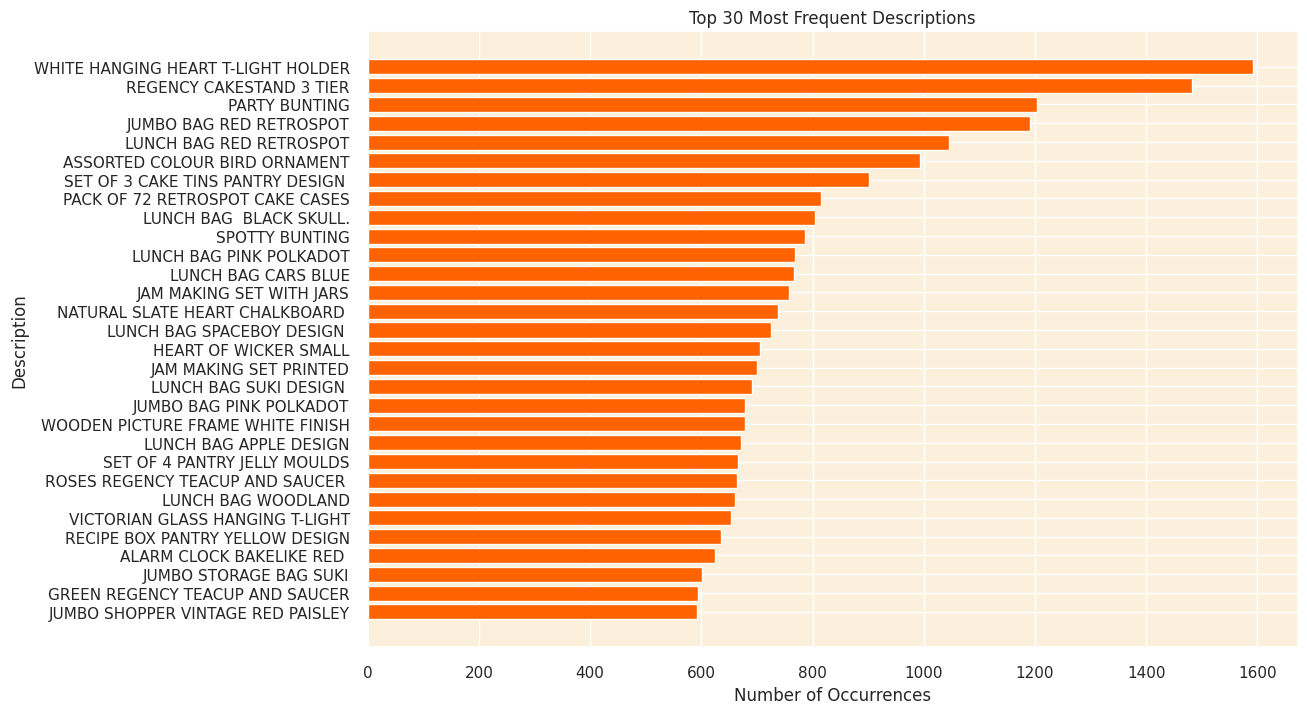

In [84]:
#Step 3.5 Cleaning Description Column
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [83]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
  print(desc)


The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm


In [85]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.01%


In [86]:
# Getting the number of rows in the dataframe
df.shape[0]

262882

In [87]:
#Step 3.6 Treating Zero Unit Prices
df['UnitPrice'].describe()

,UnitPrice
count,262882.000000
mean,2.988611
std,5.002790
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


In [88]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,20.000000
mean,51.800000
std,72.865124
min,1.000000
25%,3.500000
50%,13.500000
75%,84.000000
max,240.000000


In [89]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

In [90]:
#Step 3.7 Outlier Treatment
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [91]:
# Getting the number of rows in the dataframe
df.shape[0]

262862

In [92]:
#Step 4.1 RFM Features
#Step 4.1.1 Recency (R)

# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [93]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,253
1,12347.0,57
2,12348.0,3
3,12350.0,238
4,12352.0,8


In [94]:
#Step 4.1.2 Frequency (F)
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,253,2,0.0
1,12347.0,57,5,1590.0
2,12348.0,3,4,2332.0
3,12350.0,238,1,196.0
4,12352.0,8,6,287.0


In [98]:
#Step 4.1.3 Monetary (M)

# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,253,2,0.0,0.00,0.000000
1,12347.0,57,5,1590.0,2790.86,558.172000
2,12348.0,3,4,2332.0,1437.24,359.310000
3,12350.0,238,1,196.0,294.40,294.400000
4,12352.0,8,6,287.0,807.43,134.571667


In [100]:
#Step 4.2 Product Diversity
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased_x,Unique_Products_Purchased_y
0,12346.0,253,2,0.0,0.00,0.000000,1,1
1,12347.0,57,5,1590.0,2790.86,558.172000,82,82
2,12348.0,3,4,2332.0,1437.24,359.310000,21,21
3,12350.0,238,1,196.0,294.40,294.400000,16,16
4,12352.0,8,6,287.0,807.43,134.571667,38,38


In [101]:
#Step 4.3 Behavioral Features

# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

                                                                                                                     # Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased_x,Unique_Products_Purchased_y,Average_Days_Between_Purchases
0,12346.0,253,2,0.0,0.00,0.000000,1,1,0.000000
1,12347.0,57,5,1590.0,2790.86,558.172000,82,82,1.934959
2,12348.0,3,4,2332.0,1437.24,359.310000,21,21,10.884615
3,12350.0,238,1,196.0,294.40,294.400000,16,16,0.000000
4,12352.0,8,6,287.0,807.43,134.571667,38,38,3.857143


In [102]:
#Step 4.4 Geographic Features
df['Country'].value_counts(normalize=True).head()

,proportion
Country,
United Kingdom,0.886553
Germany,0.024070
France,0.020296
EIRE,0.018770
Spain,0.006741


In [103]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

#Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased_x,Unique_Products_Purchased_y,Average_Days_Between_Purchases,Is_UK
0,12346.0,253,2,0.0,0.00,0.000000,1,1,0.000000,1
1,12347.0,57,5,1590.0,2790.86,558.172000,82,82,1.934959,0
2,12348.0,3,4,2332.0,1437.24,359.310000,21,21,10.884615,0
3,12350.0,238,1,196.0,294.40,294.400000,16,16,0.000000,0
4,12352.0,8,6,287.0,807.43,134.571667,38,38,3.857143,0


In [104]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

,count
Is_UK,
1,3182
0,348


In [109]:
#Step 4.5 Cancellation Insights
#Caculate the total number of transaction made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

#Calculate the number of cancelled transaction for each customer
cancelled_transaction = df[df['Transaction_Status']== 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

#Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased_x,Unique_Products_Purchased_y,Average_Days_Between_Purchases,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,253,2,0.0,0.00,0.000000,1,1,0.000000,1,1.0,0.5
1,12347.0,57,5,1590.0,2790.86,558.172000,82,82,1.934959,0,0.0,0.0
2,12348.0,3,4,2332.0,1437.24,359.310000,21,21,10.884615,0,0.0,0.0
3,12350.0,238,1,196.0,294.40,294.400000,16,16,0.000000,0,0.0,0.0
4,12352.0,8,6,287.0,807.43,134.571667,38,38,3.857143,0,3.0,0.5


In [113]:
#Step 4.6 Seasonality & Trends
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trend
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased_x,Unique_Products_Purchased_y,Average_Days_Between_Purchases,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean_x,Monthly_Spending_Std_x,Spending_Trend_x,Monthly_Spending_Mean_y,Monthly_Spending_Std_y,Spending_Trend_y
0,12346.0,253,2,0.0,0.00,0.000000,1,1,0.000000,1,1.0,0.5,0.000000,0.000000,0.000,0.000000,0.000000,0.000
1,12347.0,57,5,1590.0,2790.86,558.172000,82,82,1.934959,0,0.0,0.0,558.172000,130.495277,-34.663,558.172000,130.495277,-34.663
2,12348.0,3,4,2332.0,1437.24,359.310000,21,21,10.884615,0,0.0,0.0,359.310000,203.875689,-100.884,359.310000,203.875689,-100.884
3,12350.0,238,1,196.0,294.40,294.400000,16,16,0.000000,0,0.0,0.0,294.400000,0.000000,0.000,294.400000,0.000000,0.000
4,12352.0,8,6,287.0,807.43,134.571667,38,38,3.857143,0,3.0,0.5,269.143333,38.845935,-5.125,269.143333,38.845935,-5.125


In [114]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [115]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased_x,Unique_Products_Purchased_y,Average_Days_Between_Purchases,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean_x,Monthly_Spending_Std_x,Spending_Trend_x,Monthly_Spending_Mean_y,Monthly_Spending_Std_y,Spending_Trend_y
0,12346.0,253,2,0,0.0,0.0,1,1,0.0,1,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0
1,12347.0,57,5,1590,2790.86,558.172,82,82,1.934959,0,0,0.0,558.172,130.495277,-34.663,558.172,130.495277,-34.663
2,12348.0,3,4,2332,1437.24,359.31,21,21,10.884615,0,0,0.0,359.31,203.875689,-100.884,359.31,203.875689,-100.884
3,12350.0,238,1,196,294.4,294.4,16,16,0.0,0,0,0.0,294.4,0.0,0.0,294.4,0.0,0.0
4,12352.0,8,6,287,807.43,134.571667,38,38,3.857143,0,3,0.5,269.143333,38.845935,-5.125,269.143333,38.845935,-5.125
5,12353.0,132,1,20,89.0,89.0,4,4,0.0,0,0,0.0,89.0,0.0,0.0,89.0,0.0,0.0
6,12354.0,160,1,530,1079.4,1079.4,58,58,0.0,0,0,0.0,1079.4,0.0,0.0,1079.4,0.0,0.0
7,12355.0,142,1,240,459.4,459.4,13,13,0.0,0,0,0.0,459.4,0.0,0.0,459.4,0.0,0.0
8,12356.0,173,2,1568,2429.08,1214.54,52,52,1.454545,0,0,0.0,1214.54,1036.731678,-1466.16,1214.54,1036.731678,-1466.16
9,12358.0,78,1,98,404.86,404.86,11,11,0.0,0,0,0.0,404.86,0.0,0.0,404.86,0.0,0.0


In [116]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      3530 non-null   string 
 1   Days_Since_Last_Purchase        3530 non-null   Int64  
 2   Total_Transactions              3530 non-null   Int64  
 3   Total_Products_Purchased        3530 non-null   Int64  
 4   Total_Spend                     3530 non-null   Float64
 5   Average_Transaction_Value       3530 non-null   Float64
 6   Unique_Products_Purchased_x     3530 non-null   Int64  
 7   Unique_Products_Purchased_y     3530 non-null   Int64  
 8   Average_Days_Between_Purchases  3530 non-null   Float64
 9   Is_UK                           3530 non-null   Int64  
 10  Cancellation_Frequency          3530 non-null   Int64  
 11  Cancellation_Rate               3530 non-null   Float64
 12  Monthly_Spending_Mean_x         35

In [117]:
#Step 5 Outlier Detection and Treatment

# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased_x,Unique_Products_Purchased_y,Average_Days_Between_Purchases,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean_x,Monthly_Spending_Std_x,Spending_Trend_x,Monthly_Spending_Mean_y,Monthly_Spending_Std_y,Spending_Trend_y,Outlier_Scores,Is_Outlier
0,12346.0,253,2,0,0.0,0.0,1,1,0.0,1,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,12347.0,57,5,1590,2790.86,558.172,82,82,1.934959,0,0,0.0,558.172,130.495277,-34.663,558.172,130.495277,-34.663,1,0
2,12348.0,3,4,2332,1437.24,359.31,21,21,10.884615,0,0,0.0,359.31,203.875689,-100.884,359.31,203.875689,-100.884,1,0
3,12350.0,238,1,196,294.4,294.4,16,16,0.0,0,0,0.0,294.4,0.0,0.0,294.4,0.0,0.0,1,0
4,12352.0,8,6,287,807.43,134.571667,38,38,3.857143,0,3,0.5,269.143333,38.845935,-5.125,269.143333,38.845935,-5.125,1,0


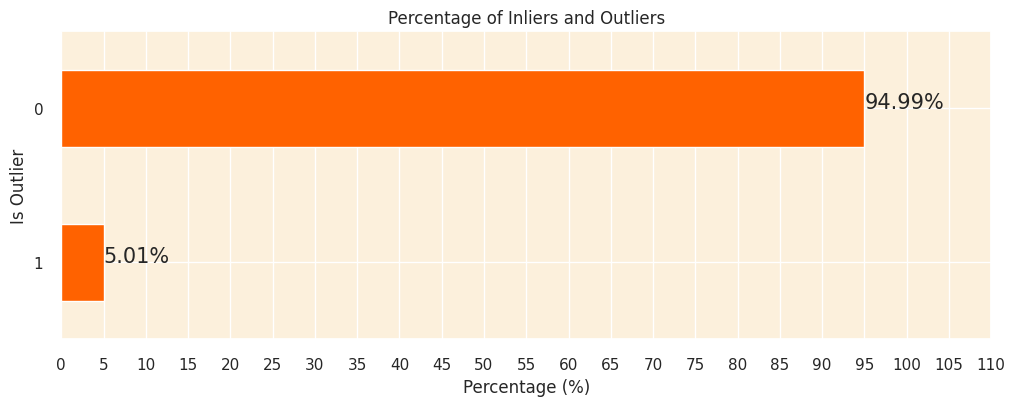

In [118]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
     plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [119]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [120]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

3353

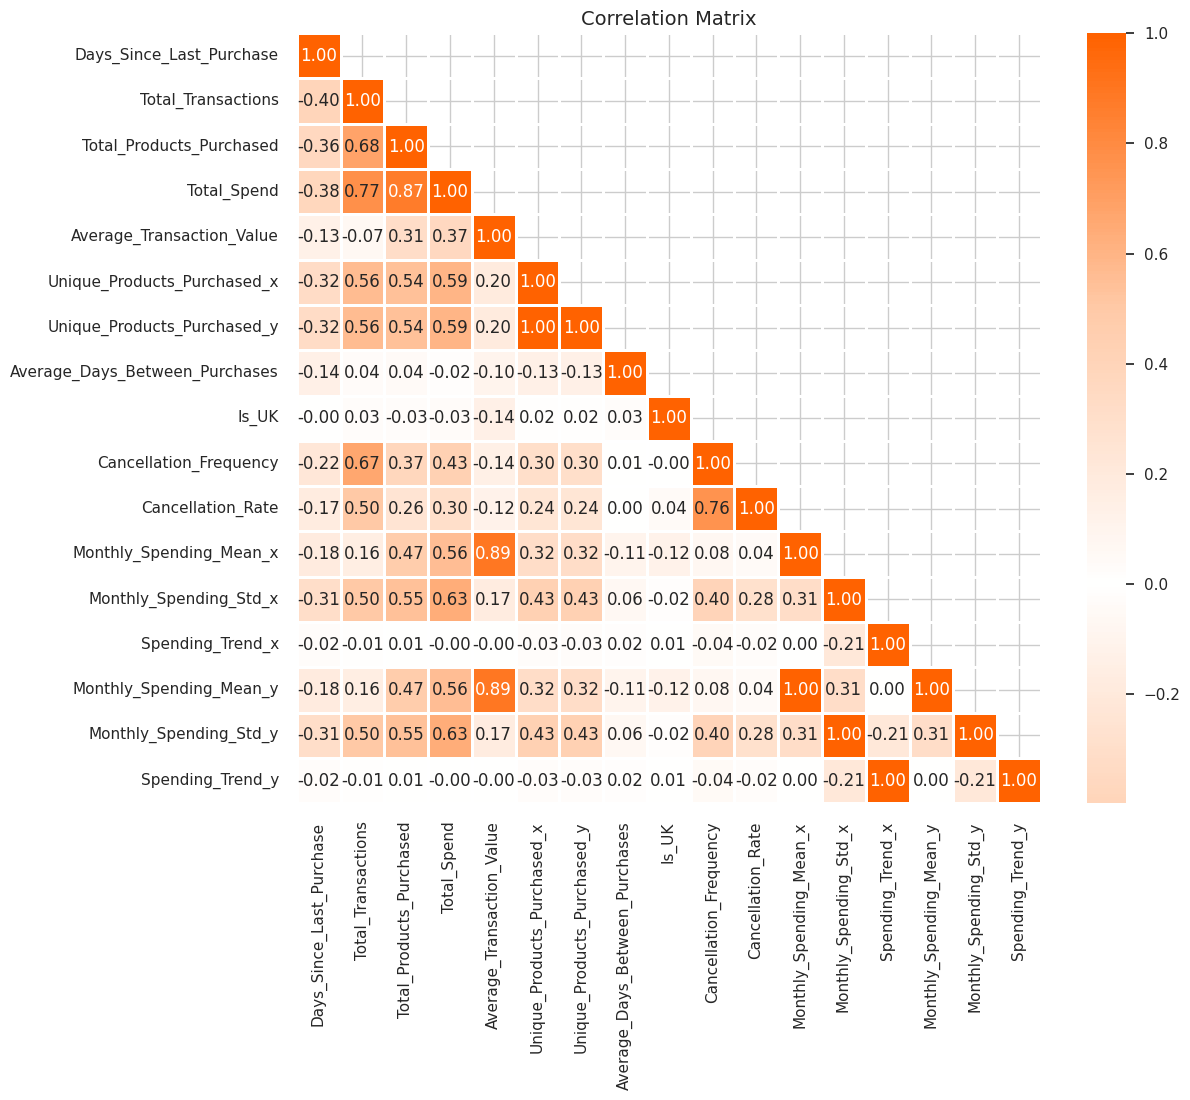

In [121]:
#Step 6 Correlation Analysis

# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)
# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [131]:
#Step 7 Feature Scaling

#Initialize the StandardScaler
scaler = StandardScaler()

#List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

#List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

#Copy the cleaned dataset
customer_to_scale = customer_data_cleaned.copy()

#Applying the scaler to the necessary columns in the dataset
customer_to_scale[columns_to_scale] = scaler.fit_transform(customer_to_scale[columns_to_scale])

#Display the first few rows of the scaled data
customer_to_scale.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased_x,Unique_Products_Purchased_y,Average_Days_Between_Purchases,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean_x,Monthly_Spending_Std_x,Spending_Trend_x,Monthly_Spending_Mean_y,Monthly_Spending_Std_y,Spending_Trend_y
0,12346.0,1.850041,-0.416127,-0.740088,-0.813476,-1.231830,-0.949817,-0.949817,-0.328227,1,0.417089,0.333421,-1.283757,-0.667644,0.104217,-1.283757,-0.667644,0.104217
1,12347.0,-0.438583,0.412913,1.329957,1.590349,1.170624,0.779556,0.779556,-0.098399,0,-0.533625,-0.424551,0.761538,0.196458,-0.126056,0.761538,0.196458,-0.126056
2,12348.0,-1.069122,0.136566,2.295979,0.424448,0.314693,-0.522811,-0.522811,0.964612,0,-0.533625,-0.424551,0.032853,0.682362,-0.565973,0.032853,0.682362,-0.565973
3,12350.0,1.674891,-0.692474,-0.484913,-0.559904,0.035311,-0.629562,-0.629562,-0.328227,0,-0.533625,-0.424551,-0.204995,-0.667644,0.104217,-0.204995,-0.667644,0.104217
4,12352.0,-1.010739,0.689259,-0.366439,-0.118020,-0.652614,-0.159856,-0.159856,0.129912,0,2.318518,0.333421,-0.297542,-0.410418,0.070170,-0.297542,-0.410418,0.070170


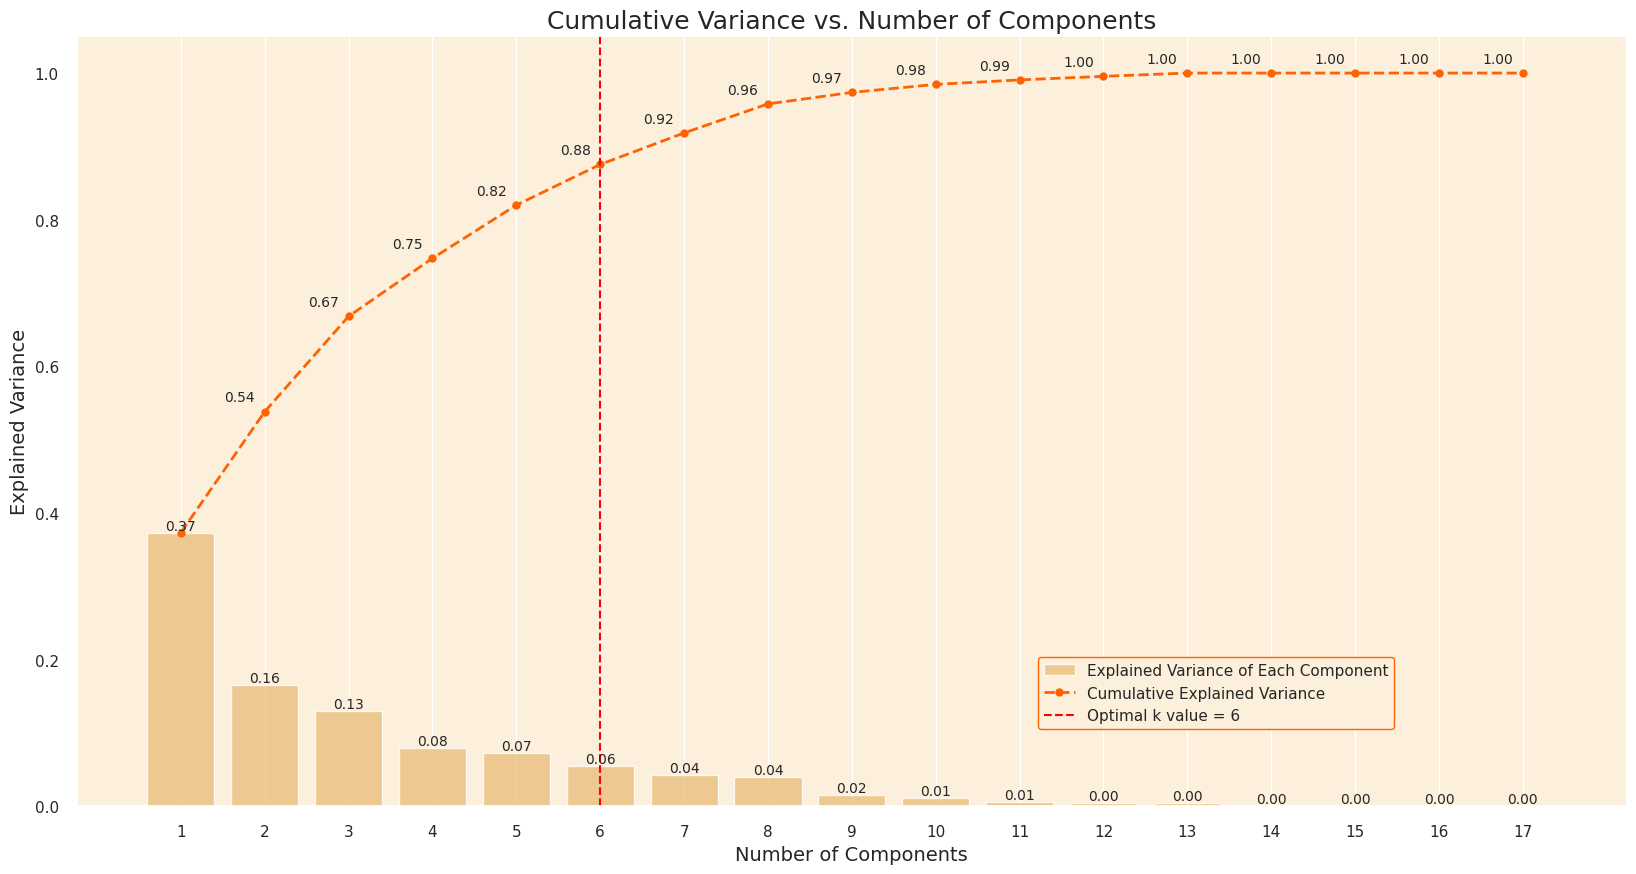

In [141]:
#Step 8 Dimensionality Reduction

#Setting CustomerID as the index column
customer_to_scale.set_index('CustomerID', inplace=True)

#Apply PCA
pca = PCA().fit(customer_to_scale)

#Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

#Set the optional k value (based on our analysis,we can choose 6)
optimal_k = 6

#Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

#Plot the cumlative explained variance againstr the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
y=explained_variance_ratio,
color='#fcc36d',
alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))

plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
loc=(0.62, 0.1),
frameon=True,
framealpha=1.0,
edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
     plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
     if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [146]:
#Creating a PCA object with 6 components
pca = PCA(n_components=6)

#Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_to_scale)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_to_scale.index

In [147]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.745969,-1.517012,0.145834,-0.050411,1.125033,0.899056
12347.0,2.257352,1.374847,-0.063008,-0.446248,-0.663131,-0.328000
12348.0,1.197265,0.118240,-0.842799,1.423134,-1.413503,-0.386703
12350.0,-1.990431,0.700926,-0.126590,-0.227395,0.614246,0.696099
12352.0,0.194938,-1.588193,0.639626,0.416873,0.987778,-1.065373


In [150]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color: #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                    index=customer_to_scale.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.192524,0.060458,-0.085416,-0.108823,0.302163,0.487331
Total_Transactions,0.309034,-0.266672,0.130234,-0.017327,0.041809,-0.113888
Total_Products_Purchased,0.336955,0.008849,0.073549,0.056523,-0.098099,-0.028999
Total_Spend,0.369540,0.018105,0.061567,0.047765,-0.044290,0.036017
Average_Transaction_Value,0.174720,0.514239,-0.074404,0.086753,0.104297,-0.089774
Unique_Products_Purchased_x,0.302906,-0.046151,0.076689,-0.498623,-0.169557,-0.098254
Unique_Products_Purchased_y,0.302906,-0.046151,0.076689,-0.498623,-0.169557,-0.098254
Average_Days_Between_Purchases,-0.013180,-0.101787,0.021713,0.547533,-0.413576,-0.421727
Is_UK,-0.004544,-0.022340,0.005548,-0.009365,-0.011954,-0.003917
Cancellation_Frequency,0.222285,-0.331074,0.083884,0.149789,0.454716,-0.076200


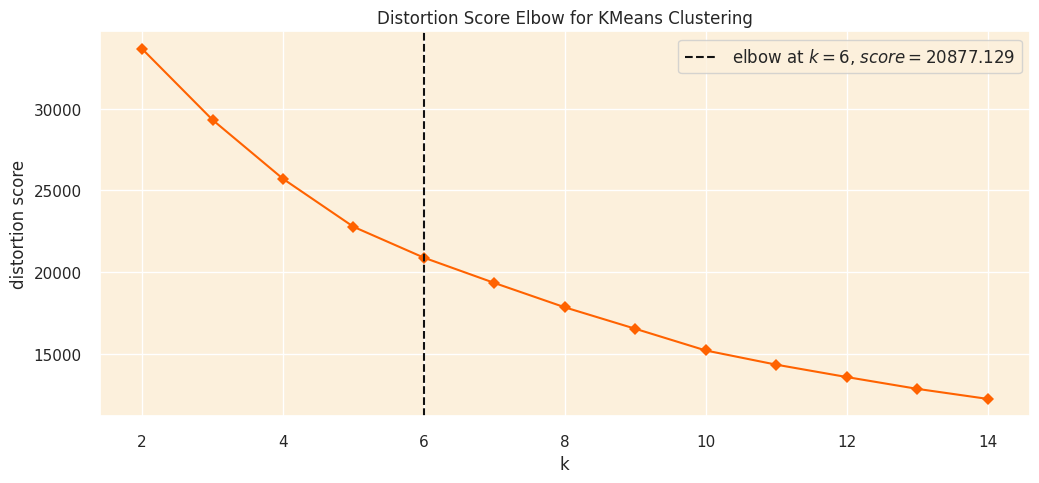

In [151]:
#Step 9 K-Means Clustering
#Step 9.1 Determining the Optimal Number of Clusters
#Step 9.1.1 Elbow Method

sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})
# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

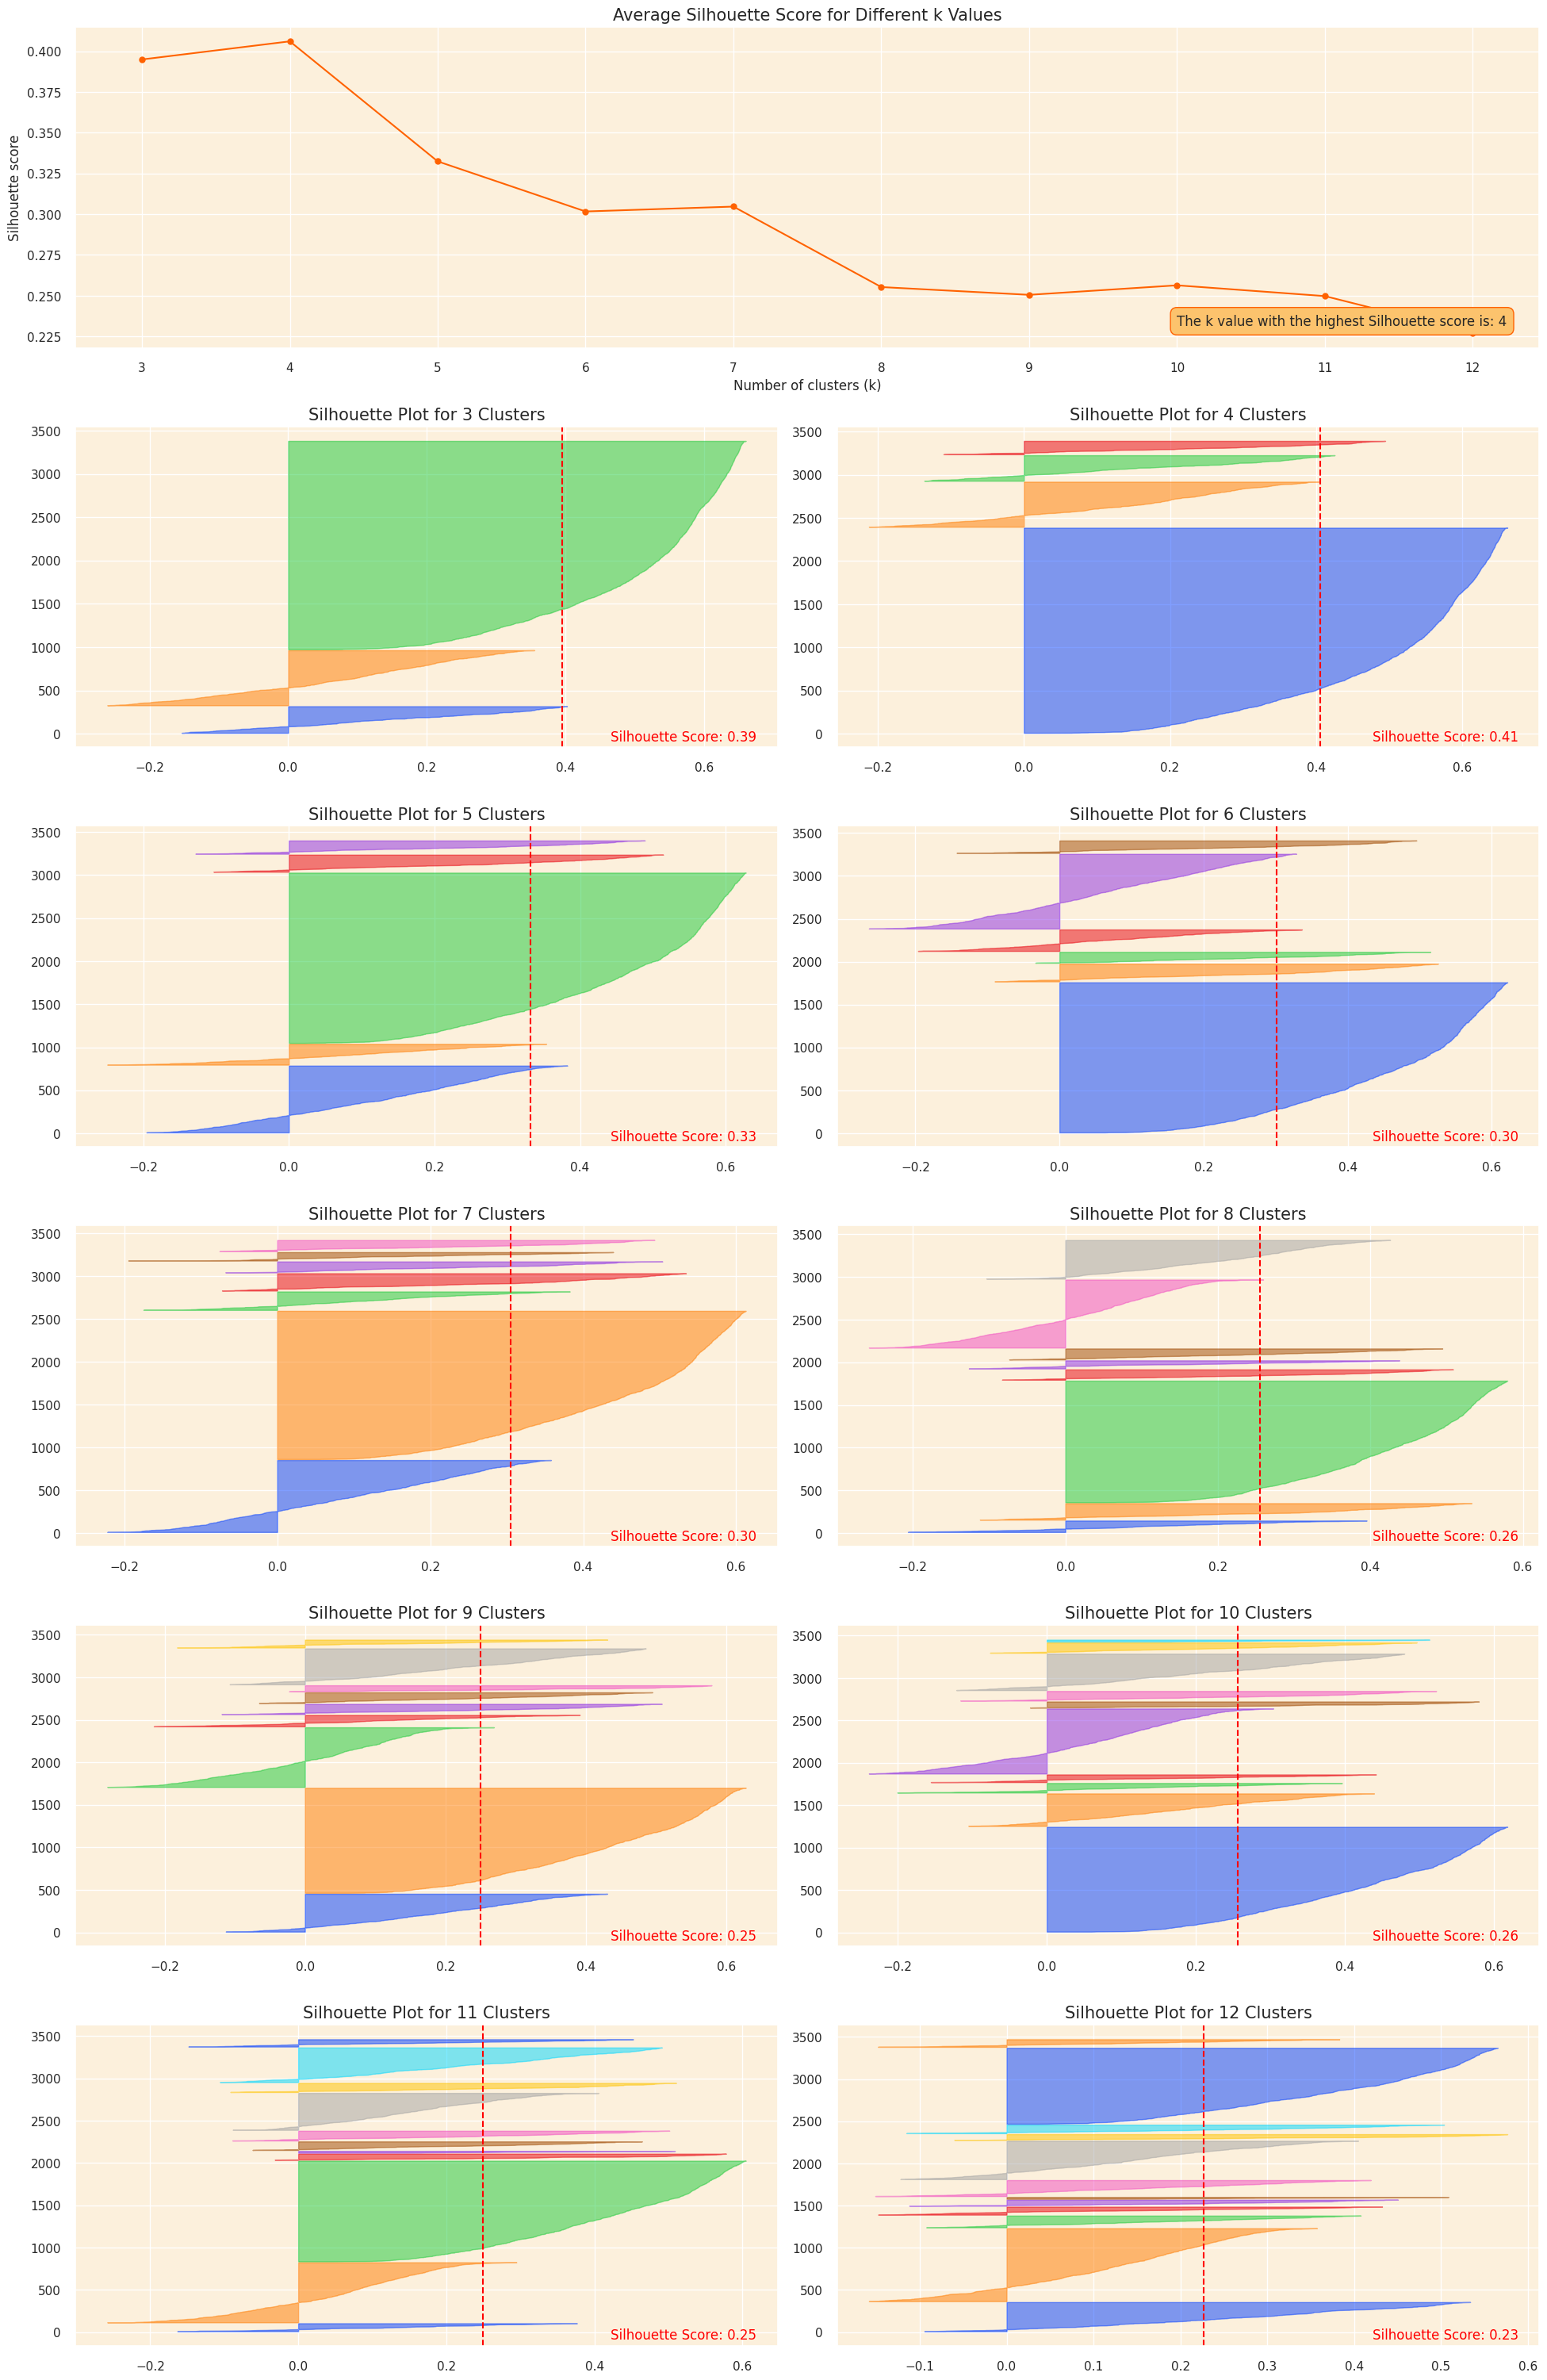

In [154]:
#Step 9.1.2 Silhouette Method

def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """
    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])
    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)
    best_k = start_k + silhouette_scores.index(max(silhouette_scores))
    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
    horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")
    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])
        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
        ha='right', transform=ax.transAxes, color='red')
        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)
    plt.tight_layout()
    plt.show()
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

In [155]:
#Step 9.2 Clustering Model - K-means

# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased_x,Unique_Products_Purchased_y,Average_Days_Between_Purchases,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean_x,Monthly_Spending_Std_x,Spending_Trend_x,Monthly_Spending_Mean_y,Monthly_Spending_Std_y,Spending_Trend_y,cluster
0,12346.0,253,2,0,0.0,0.0,1,1,0.0,1,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0
1,12347.0,57,5,1590,2790.86,558.172,82,82,1.934959,0,0,0.0,558.172,130.495277,-34.663,558.172,130.495277,-34.663,1
2,12348.0,3,4,2332,1437.24,359.31,21,21,10.884615,0,0,0.0,359.31,203.875689,-100.884,359.31,203.875689,-100.884,0
3,12350.0,238,1,196,294.4,294.4,16,16,0.0,0,0,0.0,294.4,0.0,0.0,294.4,0.0,0.0,0
4,12352.0,8,6,287,807.43,134.571667,38,38,3.857143,0,3,0.5,269.143333,38.845935,-5.125,269.143333,38.845935,-5.125,0


In [158]:
#Step 10 Clustering Evaluation

# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]
# Create a 3D scatter plot
fig = go.Figure()
# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
scene=dict(
xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
),
width=900,
height=800
)
# Show the plot
fig.show()

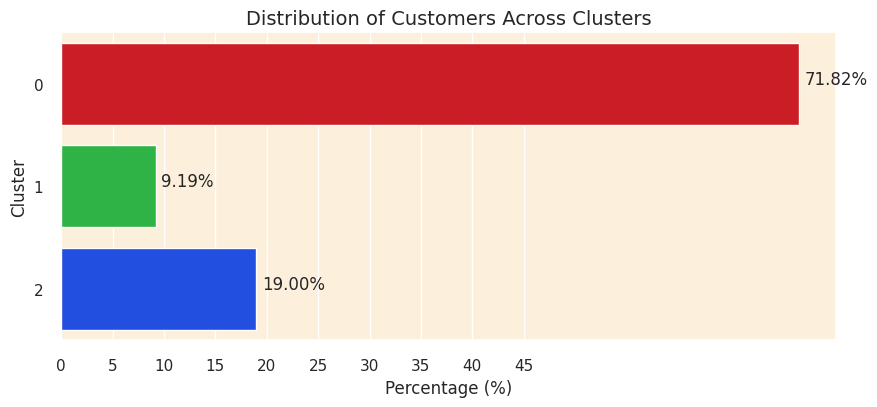

In [160]:
#Step 10.2 Cluster Distribution Visualization

# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)
# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)
# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')
plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')
# Show the plot
plt.show()

In [161]:
#Step 10.3 Evaluation Metrics

# Compute number of customers
num_observations = len(customer_data_pca)
# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']
# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)
# Create a table to display the metrics and the number of observations
table_data = [
["Number of Observations", num_observations],
["Silhouette Score", sil_score],
["Calinski Harabasz Score", calinski_score],
["Davies Bouldin Score", davies_score]
]
# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        3353         |
|    Silhouette Score     | 0.39490813772619976 |
| Calinski Harabasz Score | 1021.8681094990765  |
|  Davies Bouldin Score   |  1.351563904456918  |
+-------------------------+---------------------+


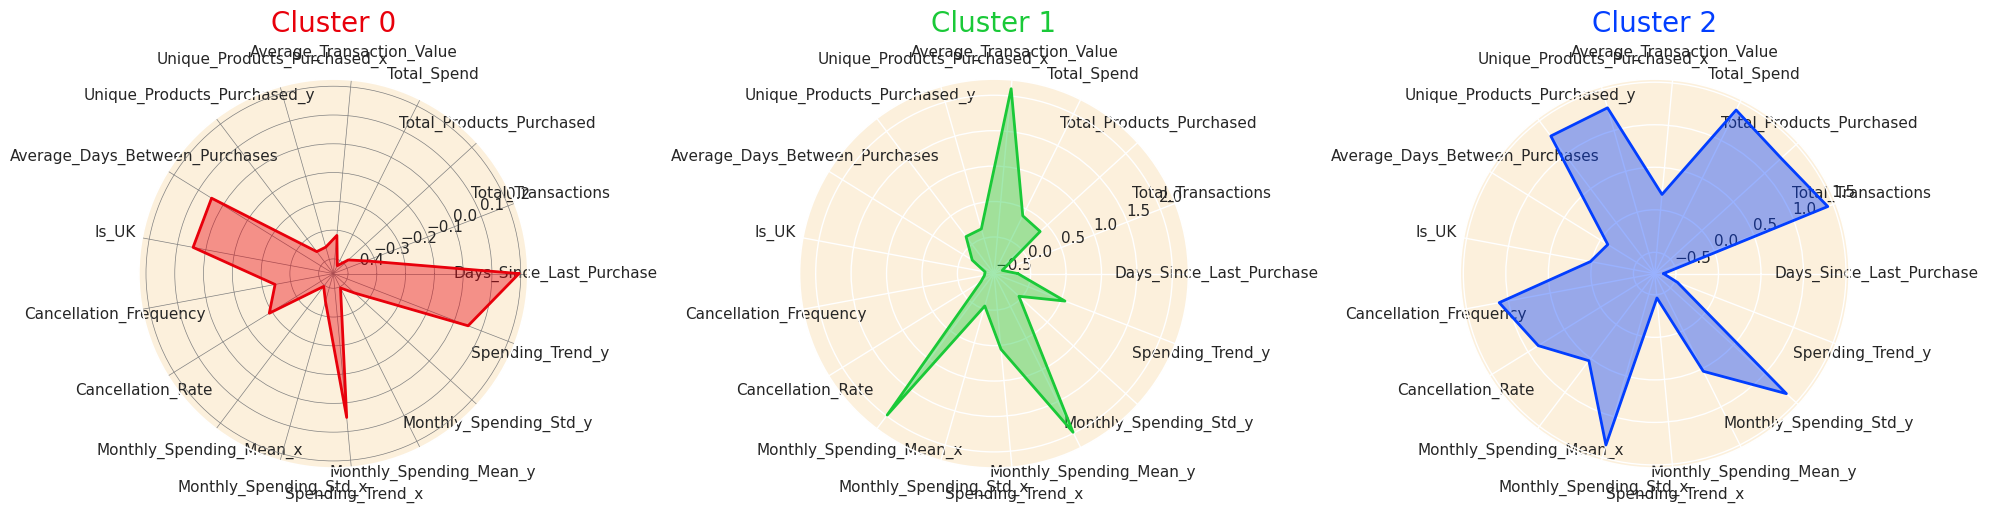

In [165]:
#Step 11 Cluster Analysis and Profiling
#setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')
# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))
# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']
# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()
# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
     # Plot the data and fill the area
     ax.fill(angles, data, color=color, alpha=0.4)
     ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
     # Add a title
     ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)
# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)
# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]
# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)
# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1] # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)
# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])
ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])
ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])
# Add a grid
ax[0].grid(color='grey', linewidth=0.5)
# Display the plot
plt.tight_layout()
plt.show()

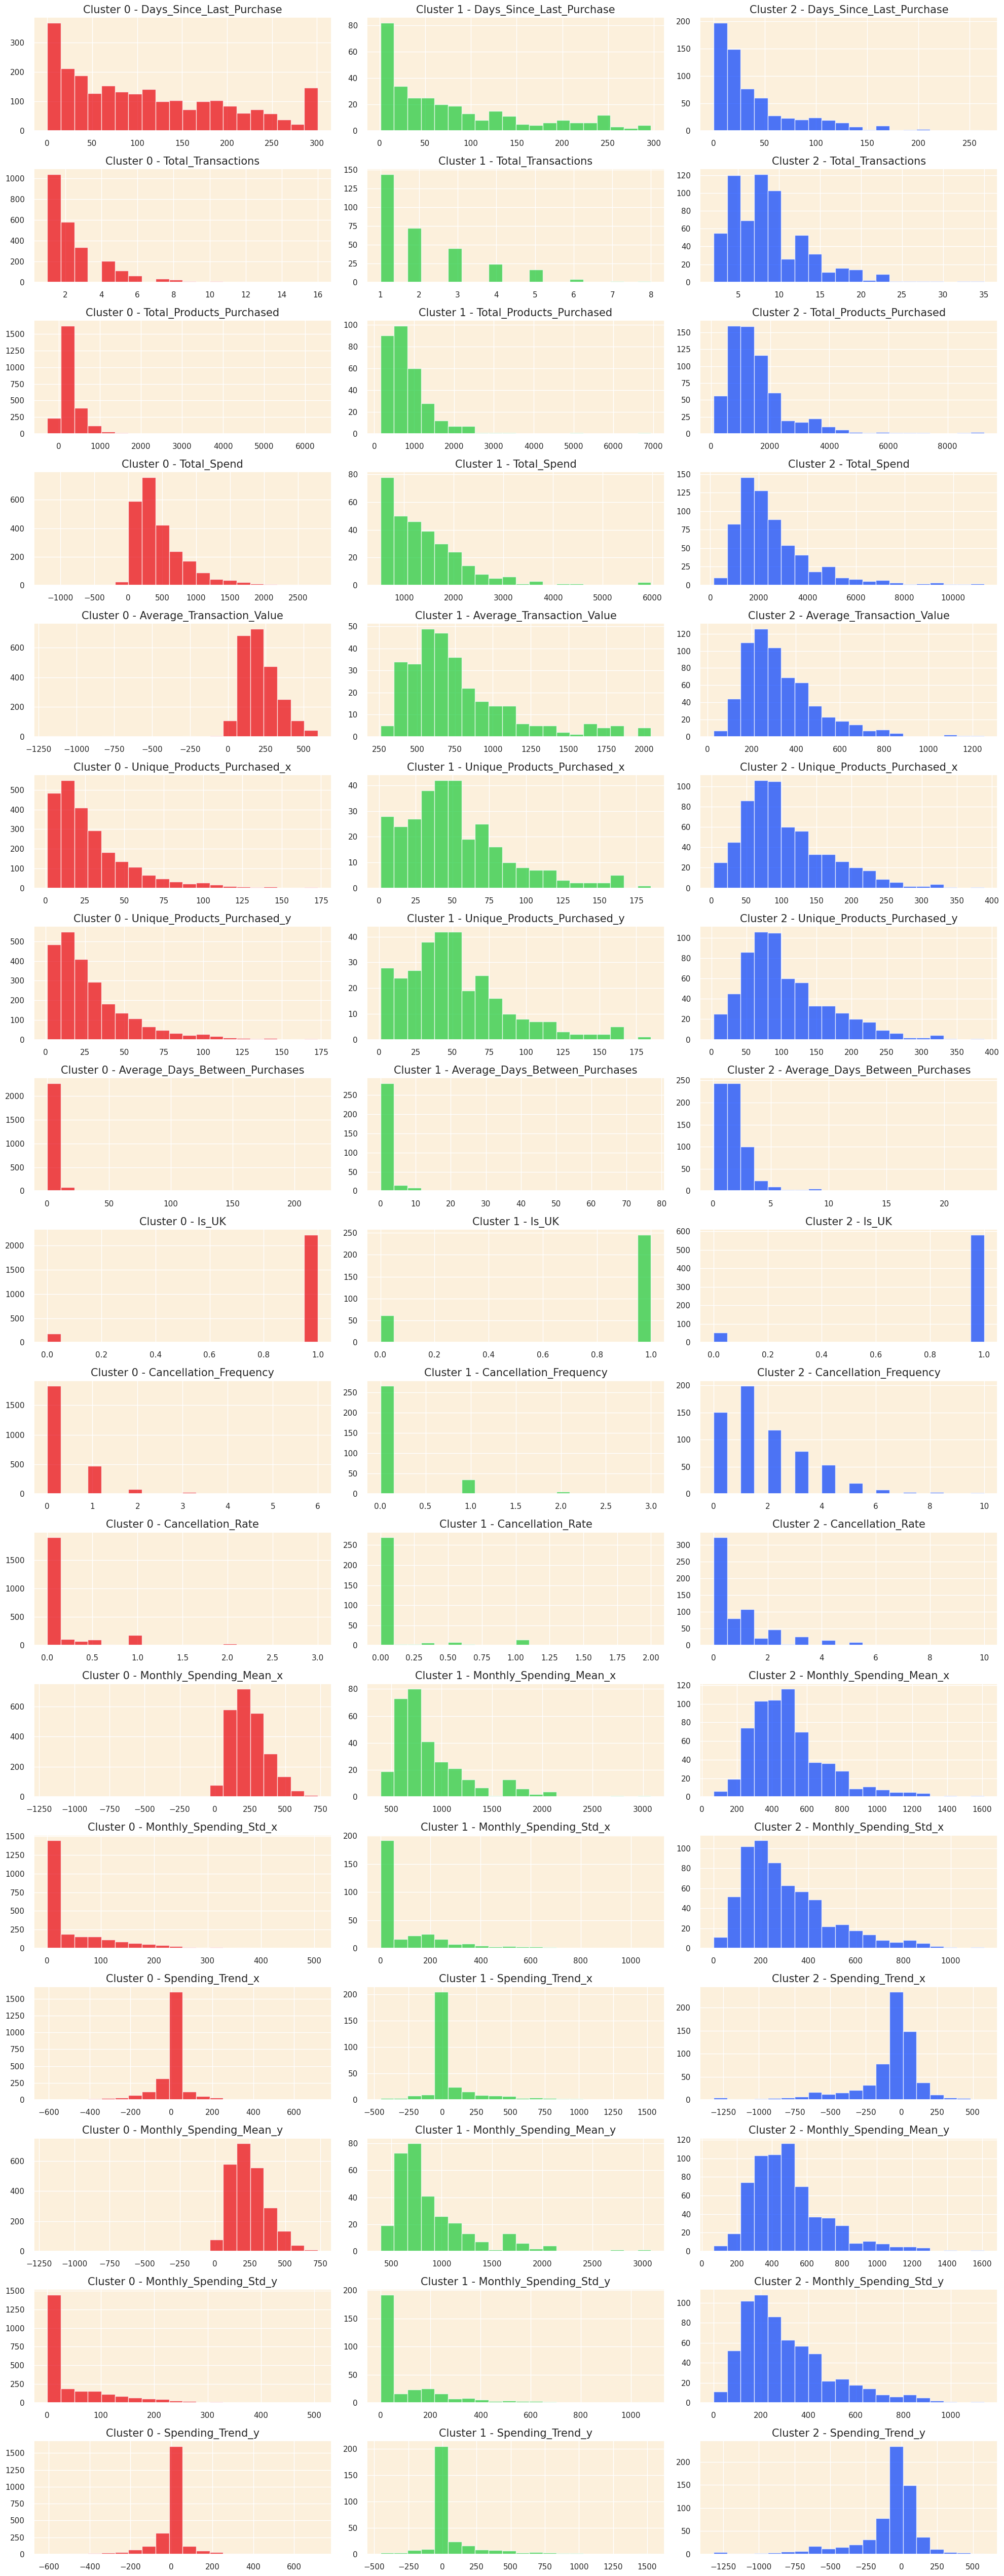

In [170]:
#Step 11.2 Histogram Chart Approach
#Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()
# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()